In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer, sentencepiece_numericalizer
from tqdm import trange, tqdm

In [91]:
learning_rate = 1e-4

nepochs = 20

batch_size = 32

max_len = 64

root = "datasets"

In [93]:
# AGNews dataset class definition
class AGNews(Dataset):
    def __init__(self, test_train="train"):
        # Read the AG News dataset CSV file based on the test_train parameter (train or test)
        self.df = pd.read_csv(os.path.join(data_set_root, "datasets/" + test_train + ".csv"),
                              names=["Class", "Title", "Content"])
        
        # Fill missing values with empty string
        self.df.fillna('', inplace=True)
        
        # Combine Title and Content columns into a single Article column
        self.df['Article'] = self.df['Title'] + " : " + self.df['Content']
        
        # Drop Title and Content columns as they are no longer needed
        self.df.drop(['Title', 'Content'], axis=1, inplace=True)
        
        # Replace special characters with whitespace in the Article column
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)

    # Method to get a single item from the dataset
    def __getitem__(self, index):
        # Get the text of the article at the given index, converted to lowercase
        text = self.df.loc[index]["Article"].lower()

        return text

    # Method to get the length of the dataset
    def __len__(self):
        # Return the total number of articles in the dataset
        return len(self.df)

In [94]:
dataset_train = AGNews(test_train="train")
dataset_test = AGNews(test_train="test")
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last = True)

In [95]:
# Load the SentencePiece model (created from our dataset)
sp_model = load_sp_model("spm_ag_news.model")

# Create a tokenizer using the loaded model
tokenizer = sentencepiece_tokenizer(sp_model)

# Example tokenization
# Iterate over tokens generated by the tokenizer
for token in tokenizer(["i am creating"]):
    print(token)

['▁i', '▁am', '▁creat', 'ing']


In [96]:
# Define a function to yield tokens from a file
def yield_tokens(file_path):
    # Open the file in UTF-8 encoding
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate over each line in the file
        for line in f:
            # Yield the token split by tab character
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library (build_vocab_from_iterator)
# Builds a generator object, that is treated like an iterator
# Define special tokens with special_first=True to place them at the beginning of the vocabulary

vocab = build_vocab_from_iterator(
    yield_tokens("spm_ag_news.vocab"),
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

# Set default index for out-of-vocabulary tokens
vocab.set_default_index(vocab['<unk>'])

In [97]:
print(vocab['<pad>'])  # Should print the index of <pad>
print(vocab['<sos>'])  # Should print the index of <sos>
print(vocab['<eos>'])  # Should print the index of <eos>
print(vocab['<unk>'])  # Should print the index of <unk>
print(vocab['▁booafsffdsafsfsasafdsddio'])   # Should print the index of ▁the (if present)
# If the token is not indexable (is not in the vocabulary, then the tokenizer will return the <unk> token
print(vocab['unknown_token'])  # Should print the index of <unk> as it's not in vocab

0
1
2
3
3
3


In [98]:
class TokenDrop(nn.Module):
    """ For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    prob (float): probability of dropping a token
    pad_token (int): index for the <pad> token
    num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p = prob
        # Create a mask where 1 means we will replace that token
        # Discrete probability distribution
        # Here we want to treat the ones as the indexes to drop
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # Only replace if the token is not a special token
        # Ones or zeros. If cannot drop, 0, if can drop, 1
        can_drop = (sample >= self.num_special).long()
        # Multiply together to get the corresponding tokens to be dropped and not dropped
        # Here, 1 represents drop, 0 represents do not drop
        mask = mask * can_drop

        # Make a mask of pad_token to use for replacing dropped indices with the pad_token
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        """ Sample is the original sample
        The mask indicates what tokens can be replaced (0 to not be replaced, 1 to be replaced)
        Replace_with is a list of of the pad_token tokens
        Here, (1-mask) creates the complement mask. (now, 0 indicates drop, 1 indicates to not drop)
        1-1 = 0, 1-0 = 0
        Multiplying by sample, retains the original tokens that are not to be kept, and applies the mask on the sample
        Here, mask * replace_with does elementwise multiplication and adds the corresponding pad_token to the tokens replaced
        """
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [99]:
# Maximum sequence length for text inputs

# Data transform to turn text into vocab tokens
train_transform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("spm_ag_news.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(vocab['<sos>'], begin=True),
    # Crop the sentance if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(vocab['<eos>'], begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

# Removed padding function
# # Custom padding function
# def pad_sequence(seq, max_len, padding_value):
#     if len(seq) < max_len:
#         seq += [padding_value] * (max_len - len(seq))
#     return seq[:max_len]
# Define a transformation pipeline for generation (without truncation)
gen_transform = T.Sequential(
    # Tokenize sentences using pre-existing SentencePiece tokenizer model
    T.SentencePieceTokenizer("spm_ag_news.model"),
    # Convert tokens to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> token at the beginning of each sentence (index 1 in vocabulary)
    T.AddToken(1, begin=True),
    # Convert the list of lists to a tensor and pad sentences with the <pad> token if shorter than max length
    T.ToTensor(padding_value=0)
)

In [133]:
text = next(iter(data_loader_train)) # Batch of strings
input_tokens = train_transform(text) # Tokenize the batch
# All input tokens are of length 65
print(input_tokens.shape)
print("SENTENCE")
# Inital text
print(text[0])
print("TOKENS")
print(vocab.lookup_tokens(input_tokens[0].numpy()))

torch.Size([32, 65])
SENTENCE
qyntel woods suspension protested : portland trail blazers players are protesting the suspension of teammate qyntel woods because of allegations involving dogfighting.
TOKENS
['<sos>', '▁q', 'yn', 'tel', '▁woods', '▁suspension', '▁protest', 'ed', '▁:', '▁portland', '▁trail', '▁blazers', '▁players', '▁are', '▁protesting', '▁the', '▁suspension', '▁of', '▁teammate', '▁q', 'yn', 'tel', '▁woods', '▁be', 'cause', '▁of', '▁allegations', '▁in', 'volving', '▁dog', 'fighting', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [134]:
input_tokens[0].numpy()

array([    1, 15393,  3653,  3239, 19781, 18067, 15276,  1071,  4553,
       14963, 18666,  5968, 14822,  5235, 15280, 18412, 18067, 14005,
       18268, 15393,  3653,  3239, 19781,  5728,   700, 14005,  4952,
       11224,  3518,  8532,  1285,    50,     2,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [138]:
print("TOKENS BACK TO SENTENCE")

pred_text = "".join(vocab.lookup_tokens(input_tokens[0].numpy()))
pred_text

TOKENS BACK TO SENTENCE


'<sos>▁qyntel▁woods▁suspension▁protested▁:▁portland▁trail▁blazers▁players▁are▁protesting▁the▁suspension▁of▁teammate▁qyntel▁woods▁because▁of▁allegations▁involving▁dogfighting.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [141]:
class LSTM(nn.Module):
    def __init__(self, num_emb, num_layers=1, emb_size=128, hidden_size=128):
        super(LSTM, self).__init__()
        
        self.embedding = nn.Embedding(num_emb, emb_size) # (vocab_size, emb_size)

        self.mlp_emb = nn.Sequential(nn.Linear(emb_size, emb_size),
                                     nn.LayerNorm(emb_size),
                                     nn.ELU(),
                                     nn.Linear(emb_size, emb_size))
        
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.25)

        self.mlp_out = nn.Sequential(nn.Linear(hidden_size, hidden_size//2),
                                     nn.LayerNorm(hidden_size//2),
                                     nn.ELU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(hidden_size//2, num_emb))
        
    def forward(self, input_seq, hidden_in, mem_in):
        input_embs = self.embedding(input_seq) # (bs, t, emb_size) 
        input_embs = self.mlp_emb(input_embs) # (bs, t, emb_size) 
                
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in)) 

        # (bs, t, hidden_size) 
        # (num_layers, bs, hidden_size) 
        # (num_layers, bs, hidden_size) 
                
        return self.mlp_out(output), hidden_out, mem_out

        # (bs, t, vocab_size)

In [142]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

emb_size = 128

hidden_size = 512

num_layers = 2

lstm_generator = LSTM(num_emb=len(vocab), num_layers=num_layers, 
                      emb_size=emb_size, hidden_size=hidden_size).to(device)

optimizer = optim.Adam(lstm_generator.parameters(), lr=learning_rate, weight_decay=1e-4)

loss_fn = nn.CrossEntropyLoss()

td = TokenDrop(prob=0.1)

training_loss_logger = []

entropy_logger = []

In [149]:
import sys

In [ ]:
# Training loop
for epoch in range(nepochs):
    # Set LSTM generator model to training mode
    lstm_generator.train()
    steps = 0
    # Iterate over batches in training data loader
    for text in data_loader_train:
        
        # Transform text tokens using training transform and move to device
        # tuple -> list -> tensor
        text_tokens = train_transform(list(text)).to(device)
        
        bs = text_tokens.shape[0]
        
        # Randomly drop input tokens
        # All batches
        # Here, we are secretly cutting the text at the end
        # T = 64
        input_text = td(text_tokens[:, 0:-1]) # (bs, T)
        output_text = text_tokens[:, 1:] # # (bs, T)
        
        # Initialize the memory buffers
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device) # (2, bs, hidden_size)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device) # (2, bs, hidden_size)
        
        # Forward pass through the LSTM generator
        pred, hidden, memory = lstm_generator(input_text, hidden, memory) # (bs, T, vocab_size)

        # Calculate loss
        loss = loss_fn(pred.transpose(1, 2), output_text) # (bs, vocab_size, T) & (bs, T)
        
        # Zero gradients, perform backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss)
        
        # Log training loss
        training_loss_logger.append(loss.item())
        
        # Log entropy during training (for monitoring)
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())

tensor(5.6558, grad_fn=<NllLoss2DBackward0>)
tensor(5.5986, grad_fn=<NllLoss2DBackward0>)
tensor(5.7253, grad_fn=<NllLoss2DBackward0>)
tensor(5.7097, grad_fn=<NllLoss2DBackward0>)
tensor(5.5408, grad_fn=<NllLoss2DBackward0>)
tensor(6.0220, grad_fn=<NllLoss2DBackward0>)
tensor(5.4783, grad_fn=<NllLoss2DBackward0>)
tensor(6.2306, grad_fn=<NllLoss2DBackward0>)
tensor(5.7847, grad_fn=<NllLoss2DBackward0>)
tensor(5.7985, grad_fn=<NllLoss2DBackward0>)
tensor(5.6642, grad_fn=<NllLoss2DBackward0>)
tensor(5.4343, grad_fn=<NllLoss2DBackward0>)
tensor(5.6503, grad_fn=<NllLoss2DBackward0>)
tensor(5.4600, grad_fn=<NllLoss2DBackward0>)
tensor(5.8506, grad_fn=<NllLoss2DBackward0>)
tensor(5.6880, grad_fn=<NllLoss2DBackward0>)
tensor(5.6587, grad_fn=<NllLoss2DBackward0>)
tensor(5.7995, grad_fn=<NllLoss2DBackward0>)
tensor(5.7212, grad_fn=<NllLoss2DBackward0>)
tensor(5.7331, grad_fn=<NllLoss2DBackward0>)
tensor(6.1393, grad_fn=<NllLoss2DBackward0>)
tensor(5.7952, grad_fn=<NllLoss2DBackward0>)
tensor(5.3

In [1]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[100:])
_ = plt.title("Training Loss")

NameError: name 'plt' is not defined

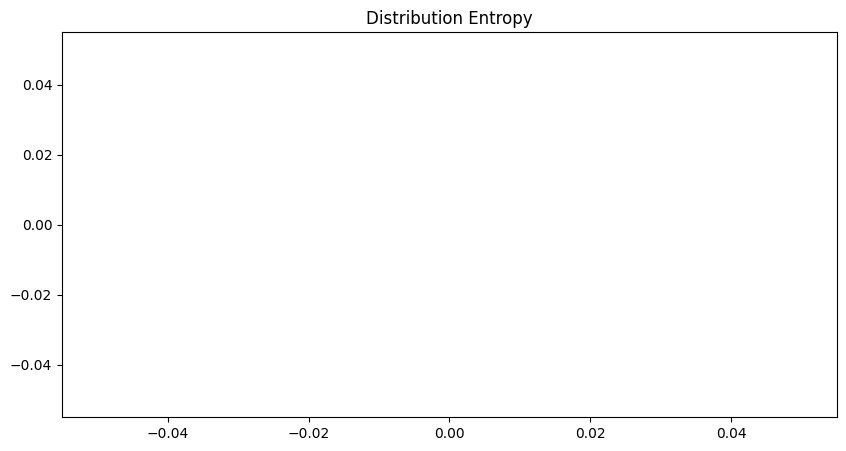

In [157]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(entropy_logger[1000:])
_ = plt.title("Distribution Entropy")

In [164]:
# Get some test examples
text = next(iter(data_loader_test))

In [165]:
# Choose an index from the test data loader
index = 0

# Temperature parameter for sampling
temp = 0.9

# We can either use an example from the test set or create our own article title!
# init_prompt = ["the next big thing from google :"]
init_prompt = [text[index].split(":")[0] + ":"]

# Transform the initial prompt into tokens and move to device
input_tokens = gen_transform(init_prompt).to(device)

print("INITIAL PROMPT:")
print(init_prompt[0])

print("\nPROMPT TOKENS:")
print(input_tokens)
print(vocab.lookup_tokens(input_tokens[0].cpu().numpy()))

INITIAL PROMPT:
firefox browser to hit 1.0 milestone :

PROMPT TOKENS:
tensor([[    1,  9677,  6307, 18552, 10856,  3960, 13210,  4553]])
['<sos>', '▁firefox', '▁browser', '▁to', '▁hit', '▁1.0', '▁milestone', '▁:']


In [166]:
log_tokens = []

# Set LSTM generator model to evaluation mode
lstm_generator.eval()

# Disable gradient calculation
with torch.no_grad():    
    # Initialize hidden and memory states
    hidden = torch.zeros(num_layers, 1, hidden_size, device=device)
    memory = torch.zeros(num_layers, 1, hidden_size, device=device)
    
    # Generate text
    for i in range(100):
        # Forward pass through LSTM generator
        data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)
        
        # Sample from the distribution of probabilities (with temperature)
        dist = Categorical(logits=data_pred[:, -1] / temp)
        input_tokens = dist.sample().reshape(1, 1)
        
        # Append generated token to log_tokens
        log_tokens.append(input_tokens.cpu())
        
        # Check for end-of-sentence token
        if input_tokens.item() == 2:
            break

In [167]:
# Lets look at the raw tokens
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))
print(pred_text)

▁eyes▁movies▁saratogaap▁to▁criticss.▁#▁sudan▁15<eos>


In [168]:
# Combine the model's output with the initial title to get our article!
init_prompt[0] + pred_text.replace("▁", " ").replace("<unk>", "")

'firefox browser to hit 1.0 milestone : eyes movies saratogaap to criticss. # sudan 15<eos>'

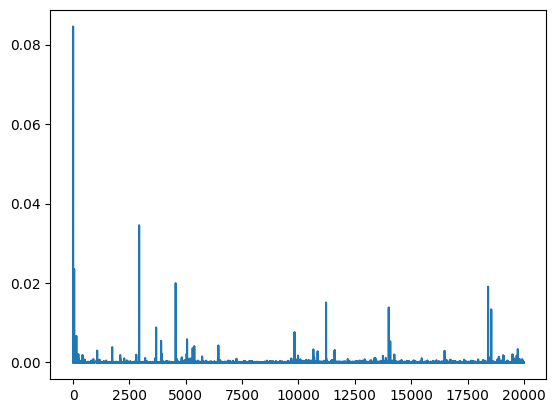

In [170]:
# Lets have a look at the probabilities
_ = plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())